In [94]:
import re
import os
import json
from PIL import Image
import io
import numpy as np
import cv2
from utils import *
from matplotlib import pyplot as plt

In [95]:
data_folder = './data'
pdf_files = [data_folder + '/' + filename for filename in os.listdir('data/') if '.pdf' in filename]

In [96]:
config = {
    "username":"user1",
    "projectName":"testProject",
    "filepath":"./data/2.pdf"
}

In [97]:
doc = fitz.open("./data/5.pdf")

In [98]:
page = list(doc.pages())[4]

In [99]:
content = page.get_text('dict')

In [100]:
blocks = content["blocks"]

In [114]:
for i, block in enumerate(blocks):
    if block["type"] == 0:
        print(i)
        print(block["bbox"])
        print(len(block))

0
(150.0, 59.87000274658203, 517.6799926757812, 87.20999908447266)
1
(149.99993896484375, 97.87000274658203, 521.3299560546875, 265.2099914550781)
2
(89.99400329589844, 277.5639953613281, 197.3459930419922, 294.0879821777344)
3
(89.99598693847656, 299.9739990234375, 112.22598266601562, 313.7440185546875)
4
(149.9959716796875, 317.8739929199219, 522.6859130859375, 429.2139892578125)
5
(89.99595642089844, 441.9739990234375, 166.6759490966797, 455.7440185546875)
6
(149.99594116210938, 459.8739929199219, 516.0560302734375, 557.2139892578125)
7
(89.99597930908203, 569.9739990234375, 209.4859619140625, 583.7440185546875)
8
(149.99594116210938, 587.8740234375, 519.075927734375, 685.2140502929688)
9
(78.0, 36.29597091674805, 522.0, 46.96800231933594)
10
(177.23199462890625, 712.9760131835938, 380.7760009765625, 723.6480102539062)
11
(18.176000595092773, 75.26399230957031, 34.66400146484375, 680.73583984375)


In [110]:
matrix = fitz.Matrix(1, 1)
page_img = page.get_pixmap(matrix = matrix)
img_bytes = page_img.tobytes()
img_np = np.frombuffer(img_bytes, dtype=np.uint8)
img_cv = cv2.imdecode(img_np, flags=1)
img_cv.shape

(792, 612, 3)

In [146]:
def make_clusters(blocks, diff=5):

    def match_cluster(bbox, cluster):
        left = bbox[0]
        right = bbox[2]
        cluster_left = cluster["bboxes"][:, 0].mean()
        cluster_right = cluster["bboxes"][:, 2].mean()
        res = (abs(left - cluster_left) < diff) and (abs(right - cluster_right) < diff)
        return res

    clusters = []
    for i, block in enumerate(blocks):
        bbox = block["bbox"]
        is_matched = False
        for cluster in clusters:
            if match_cluster(bbox, cluster):
                cluster["bboxes"] = np.vstack((cluster["bboxes"], np.array(bbox)[np.newaxis]))
                cluster["lines_count"] += len(block["lines"])
                is_matched = True
                break
        if not is_matched:
            cluster = dict()
            cluster["bboxes"] = np.array(bbox)[np.newaxis]
            cluster["lines_count"] = len(block["lines"])
            clusters.append(cluster)
    return clusters

In [160]:
def get_text_bboxes(page, min_lines=15, diff=5): # rewrite: get actual text bbox for 
    content = page.get_text('dict')
    clusters = make_clusters(content["blocks"], diff=diff)
    clusters = [
        cluster for cluster in clusters if cluster["lines_count"] >= min_lines
    ]
    for cluster in clusters:
        cluster["left"] = cluster["bboxes"][:, 0].min()
        cluster["right"] = cluster["bboxes"][:, 2].max()
        cluster["top"] = cluster["bboxes"][:, 1].min()
        cluster["bottom"] = cluster["bboxes"][:, 3].max()
    return clusters

[ 18.1760006   75.26399231  34.66400146 680.73583984]
36


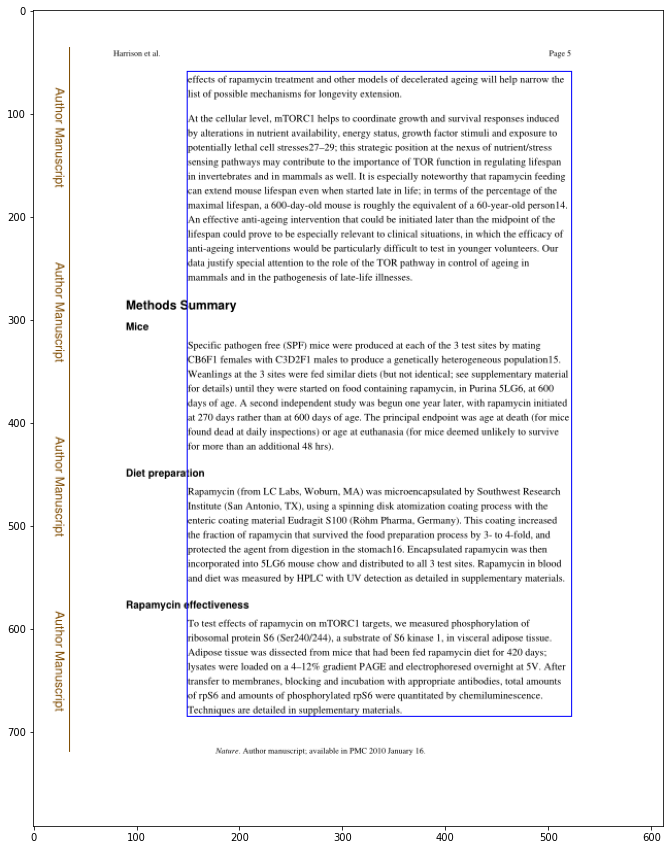

In [162]:
clusters = get_text_bboxes(page)
for cluster in clusters:
    #print(cluster)
    print(bbox)
    print(cluster["lines_count"])
    img_draw = cv2.rectangle(img_cv.copy(), (int(cluster["left"]), int(cluster["top"])), 
                                            (int(cluster["right"]), int(cluster["bottom"])), 
                                             (0, 0, 255), 1)

    plt.figure(figsize=(15, 15))
    plt.imshow(img_draw)
    plt.show()

In [40]:
for i in range(len(content["blocks"])):
    for line in content["blocks"][i]["lines"]:
        for span in line["spans"]:
            if "Protandim" in span["text"]:
                print(i, span)

0 {'size': 7.970200061798096, 'flags': 4, 'font': 'AdvPSFT-L', 'color': 2236191, 'ascender': 0.7699999809265137, 'descender': -0.23899999260902405, 'text': 'Protandim (Prot) and ﬁsh oil (FO), metformin (Met), or with the', 'origin': (43.087440490722656, 234.0828857421875), 'bbox': (43.087440490722656, 227.94583129882812, 286.9086608886719, 235.98776245117188)}
0 {'size': 7.970200061798096, 'flags': 4, 'font': 'AdvPSFT-L', 'color': 2236191, 'ascender': 0.7699999809265137, 'descender': -0.23899999260902405, 'text': 'Protandim (Prot) is a mixture of ﬁve botanical extracts, including', 'origin': (53.061344146728516, 475.1950378417969), 'bbox': (53.061344146728516, 469.0579833984375, 286.90948486328125, 477.09991455078125)}
2 {'size': 6.973800182342529, 'flags': 4, 'font': 'AdvPSFT-L', 'color': 2236191, 'ascender': 0.7699999809265137, 'descender': -0.23899999260902405, 'text': '17aE2, Protandim, NDGA, ACA and lifespan, R. Strong', 'origin': (367.08648681640625, 34.80938720703125), 'bbox': (

In [44]:
content["blocks"][1]

{'number': 1,
 'type': 0,
 'bbox': (306.70574951171875,
  52.498722076416016,
  550.5912475585938,
  707.2135009765625),
 'lines': [{'spans': [{'size': 7.970200061798096,
     'flags': 4,
     'font': 'AdvPSFT-L',
     'color': 2236191,
     'ascender': 0.7699999809265137,
     'descender': -0.23899999260902405,
     'text': 'translation (Dowling',
     'origin': (306.70574951171875, 58.72344970703125),
     'bbox': (306.70574951171875,
      52.586395263671875,
      377.6875915527344,
      60.628326416015625)},
    {'size': 7.970200061798096,
     'flags': 4,
     'font': 'AdvPSFT-LI',
     'color': 2236191,
     'ascender': 0.781000018119812,
     'descender': -0.23899999260902405,
     'text': ' et al.',
     'origin': (377.6875915527344, 58.72344970703125),
     'bbox': (377.6875915527344,
      52.498722076416016,
      400.1045837402344,
      60.628326416015625)},
    {'size': 7.970200061798096,
     'flags': 4,
     'font': 'AdvPSFT-L',
     'color': 2236191,
     'ascender':